## Task 1

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

Autoencoder architecture

In [16]:
class Autoencoder(nn.Module):

    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()


        # defining encoder layers
        encoder_layers = []
        input_dimen = input_size

        for _ in range(layers-1):
            encoder_layers.append(nn.Linear(input_dimen, hidden_size))
            encoder_layers.append(nn.ReLU())
            input_dimen = hidden_size
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))

        self.encoder = nn.Sequential(*encoder_layers)
        

        # defining decoder layers
        decoder_layers = []
        input_dimen = bottleneck_size

        for _ in range(layers-1):
            decoder_layers.append(nn.Linear(input_dimen, hidden_size))
            decoder_layers.append(nn.ReLU())
            input_dimen = hidden_size
        decoder_layers.append(nn.Linear(hidden_size, input_size))

        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


To train the model

In [17]:
def train_model(model, data, optimizer, loss_func, epochs, device, final_model=True):

    # setting model in train mode
    model.train()

    loss = 0
    losses = []

    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()

        data = data.to(device)
        output = model(data)

        loss = loss_func(output, data)
        loss.backward()

        optimizer.step()

        if final_model:
            losses.append(loss.item())
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.3f}")
            
    if final_model:
        plt.plot(np.arange(1, epochs+1), losses, marker='o')
        plt.title(f'Training reconstruction error')
        plt.xlabel('epochs')
        plt.ylabel('Reconstruction error')
        plt.grid()
        plt.show()

    return loss.item()

Setup training data

In [18]:
def generate_training_data(n_samples=1000, noise=0.1):
    data, _ = make_moons(n_samples=n_samples, noise=noise)

    data = StandardScaler().fit_transform(data)
    
    data = torch.tensor(data, dtype=torch.float32)
    return data

Setup test data

In [19]:
def generate_test_data(n_samples=1000, noise=0.1):
    data, _ = make_moons(n_samples=n_samples, noise=noise, random_state=1)

    data = StandardScaler().fit_transform(data)

    data = torch.tensor(data, dtype=torch.float32)
    return data

### 1.1

Evaluation of model's performance

In [20]:
def evaluate_model(model, test_data, loss_func, device):
    # set model in evaluation mode
    model.eval()

    total_loss = 0
    with torch.no_grad(): #ensure model's weights does not change
        test_data = test_data.to(device)
        y = model(test_data)

        loss = loss_func(y, test_data)
        total_loss+=loss.item()
    return total_loss/len(test_data)


Evaluation of hyperparamters

In [21]:
from sklearn.model_selection import train_test_split

def evaluate_hyperparameters(input_size, bottleneck_size, layers_list, hidden_size_list, n_samples_list, epochs_list, lr_list, device):

    results = []
    for n_samples in n_samples_list:
        data= generate_test_data(n_samples=n_samples, noise=0.1)
        train_data, test_data = train_test_split(data, train_size=0.5, random_state=1)
        
        for layers in layers_list:
            for hidden_size in hidden_size_list:
                for epochs in epochs_list:
                    for lr in lr_list:

                            model = Autoencoder(input_size=input_size, bottleneck_size=bottleneck_size, hidden_size=hidden_size, layers=layers).to(device)
                            optimizer = optimizer = optim.Adam(model.parameters(), lr=lr)
                            loss_func = nn.MSELoss()

                            train_model(model, train_data, optimizer, loss_func, epochs, device, final_model=False)

                            test_loss = evaluate_model(model, test_data, loss_func, device)
                            results.append({
                            'layers': layers,
                            'hidden_size': hidden_size,
                            'n_samples': n_samples,
                            'epochs': epochs,
                            'learning_rate': lr,
                            'test_loss': test_loss
                            })
                            print(f"layers={layers}, hidden_size={hidden_size}, n_samples={n_samples}, epochs={epochs}, lr={lr} -> test_loss: {test_loss:3f}")
                         
    return results

Plots evaluation of each hyperparameter

In [22]:
def plot_results(results, param_key):
    param_vals = sorted(set([result[param_key] for result in results]))
    
    mean_losses = []
    for val in param_vals:
        losses = [result['test_loss'] for result in results if result[param_key]==val]
        mean_losses.append(np.mean(losses))

    plt.plot(param_vals, mean_losses, marker='o')
    plt.title(f'Test reconstruction error for {param_key}')
    plt.xlabel(param_key)
    plt.ylabel('Reconstruction error')
    plt.grid()
    plt.show()


Initialize hyperparameter evaluation

Using cpu device
layers=2, hidden_size=16, n_samples=2000, epochs=10, lr=0.01 -> test_loss: 0.000520
layers=2, hidden_size=16, n_samples=2000, epochs=10, lr=0.005 -> test_loss: 0.000997
layers=2, hidden_size=16, n_samples=2000, epochs=10, lr=0.001 -> test_loss: 0.000849
layers=2, hidden_size=16, n_samples=2000, epochs=250, lr=0.01 -> test_loss: 0.000160
layers=2, hidden_size=16, n_samples=2000, epochs=250, lr=0.005 -> test_loss: 0.000207
layers=2, hidden_size=16, n_samples=2000, epochs=250, lr=0.001 -> test_loss: 0.000283
layers=2, hidden_size=16, n_samples=2000, epochs=500, lr=0.01 -> test_loss: 0.000141
layers=2, hidden_size=16, n_samples=2000, epochs=500, lr=0.005 -> test_loss: 0.000141
layers=2, hidden_size=16, n_samples=2000, epochs=500, lr=0.001 -> test_loss: 0.000213
layers=2, hidden_size=32, n_samples=2000, epochs=10, lr=0.01 -> test_loss: 0.000388
layers=2, hidden_size=32, n_samples=2000, epochs=10, lr=0.005 -> test_loss: 0.000713
layers=2, hidden_size=32, n_samples=2000, epoc

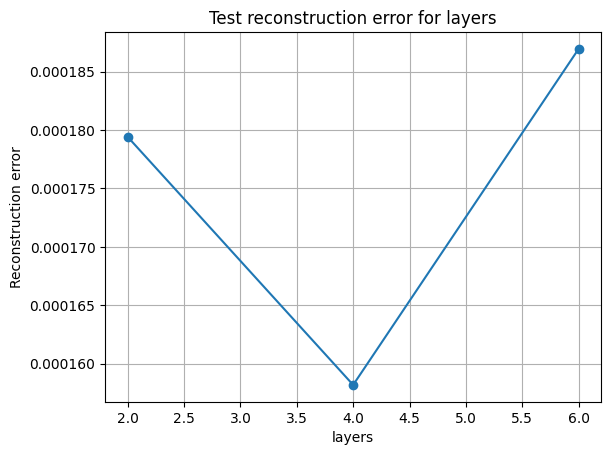

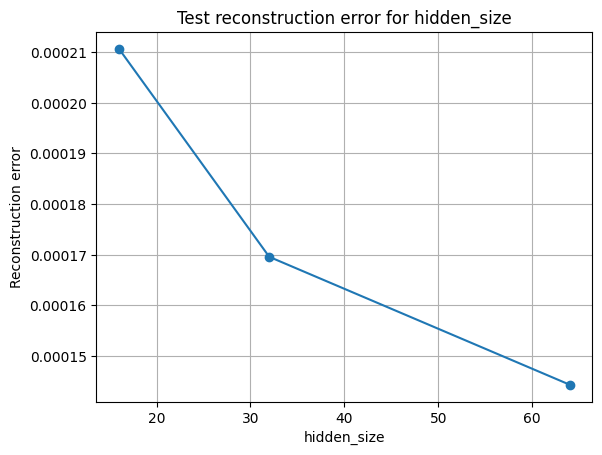

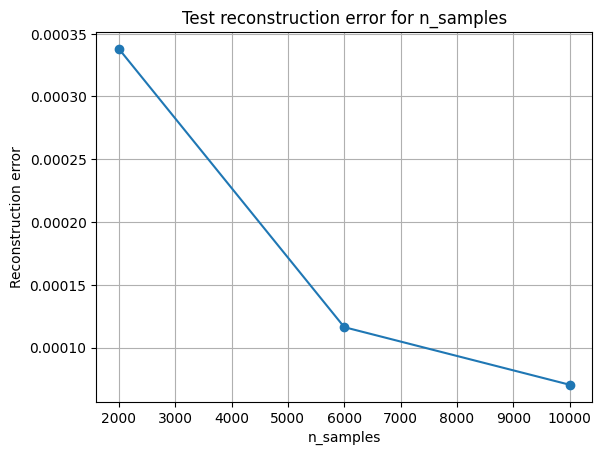

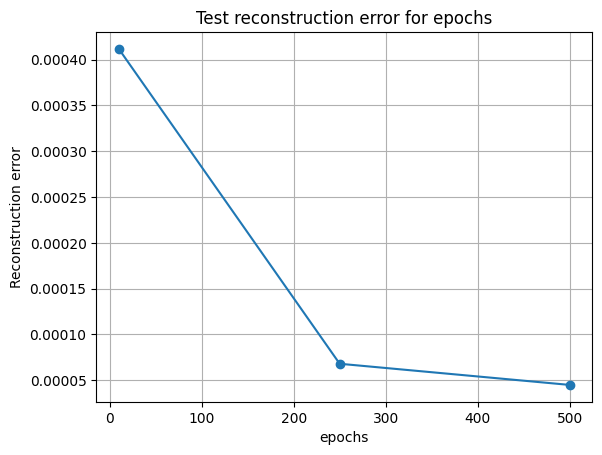

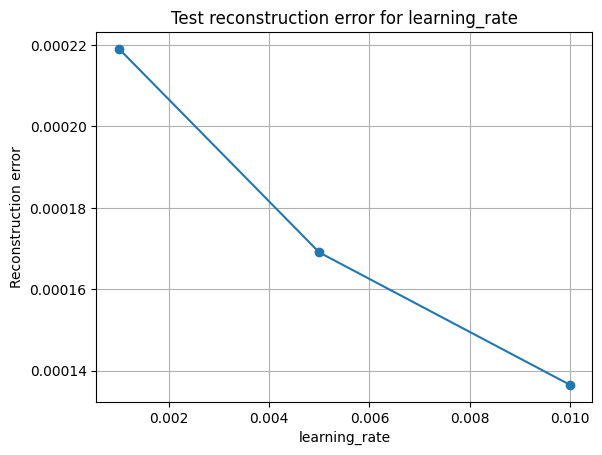

In [23]:
# initializing hyperparameters as lists for evaluation
input_size=2
bottleneck_size=1
layers_list=[2, 4, 6]
hidden_size_list=[16, 32, 64]
n_samples_list=[2000, 6000, 10000] #using 50% for training
epochs_list=[10, 250, 500]
lr_list=[0.01, 0.005, 0.001]

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


results = evaluate_hyperparameters(input_size, bottleneck_size, layers_list, hidden_size_list, n_samples_list,
                                   epochs_list, lr_list, device)


# Plot for each hyperparameter
plot_results(results, 'layers')
plot_results(results, 'hidden_size')
plot_results(results, 'n_samples')
plot_results(results, 'epochs')
plot_results(results, 'learning_rate')

**Comment**

Initializing training of final model

Using cpu device
Epoch [1/200], Loss: 1.003
Epoch [2/200], Loss: 1.000
Epoch [3/200], Loss: 0.993
Epoch [4/200], Loss: 0.973
Epoch [5/200], Loss: 0.934
Epoch [6/200], Loss: 0.875
Epoch [7/200], Loss: 0.796
Epoch [8/200], Loss: 0.685
Epoch [9/200], Loss: 0.544
Epoch [10/200], Loss: 0.416
Epoch [11/200], Loss: 0.450
Epoch [12/200], Loss: 0.463
Epoch [13/200], Loss: 0.391
Epoch [14/200], Loss: 0.353
Epoch [15/200], Loss: 0.357
Epoch [16/200], Loss: 0.368
Epoch [17/200], Loss: 0.363
Epoch [18/200], Loss: 0.347
Epoch [19/200], Loss: 0.326
Epoch [20/200], Loss: 0.310
Epoch [21/200], Loss: 0.305
Epoch [22/200], Loss: 0.309
Epoch [23/200], Loss: 0.312
Epoch [24/200], Loss: 0.305
Epoch [25/200], Loss: 0.298
Epoch [26/200], Loss: 0.302
Epoch [27/200], Loss: 0.304
Epoch [28/200], Loss: 0.297
Epoch [29/200], Loss: 0.291
Epoch [30/200], Loss: 0.292
Epoch [31/200], Loss: 0.290
Epoch [32/200], Loss: 0.282
Epoch [33/200], Loss: 0.278
Epoch [34/200], Loss: 0.278
Epoch [35/200], Loss: 0.277
Epoch [36/20

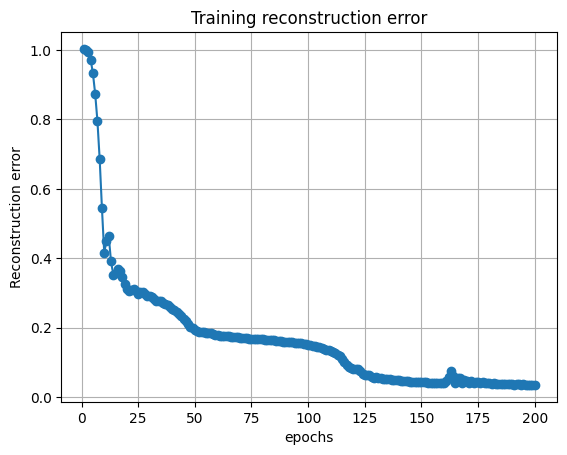

0.0351426787674427

In [36]:
# best hyperparameters
input_size = 2
bottleneck_size = 1
noise = 0.1
layers = 4
hidden_size = 64
n_samples = 3000
lr = 0.005
epochs = 200


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = Autoencoder(input_size=input_size, bottleneck_size=bottleneck_size, hidden_size=hidden_size, layers=layers).to(device)
data = generate_training_data(n_samples, noise)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()

train_model(model, data, optimizer, loss_func, epochs, device)

Results with best found hyperparameters

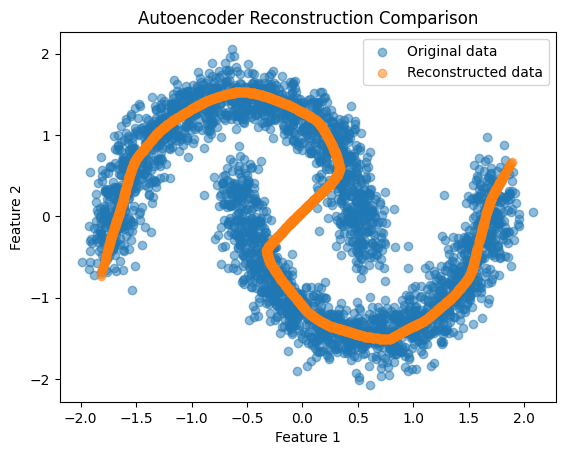

In [37]:
# best hyperparameters
noise = 0.1


data = generate_test_data(n_samples=n_samples, noise=noise)

model.eval()

with torch.no_grad():
    reconstructed_data = model(data)

plt.scatter(data[:,0], data[:,1], alpha=0.5, label="Original data")
plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], alpha=0.5, label="Reconstructed data")
plt.title("Autoencoder Reconstruction Comparison")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### 1.2

In [38]:
import pandas as pd

In [39]:
def repeat_training_experiments(num_repeat, n_samples, model, epochs, device):
    # Store reconstruction errors for each experiment
    reconstruction_errors_same_data = []
    reconstruction_errors_diff_data = []
    
    # Generate fixed data for "same data" experiments
    fixed_data = generate_training_data(n_samples, noise)
    
    for _ in range(num_repeat):
        # Repeat training with the "same dataset"
        reconstruction_error_same = train_model(model, fixed_data, optimizer, loss_func, epochs, device, final_model=False)
        reconstruction_errors_same_data.append(reconstruction_error_same)
        
        # Repeat training with "different datasets"
        diff_data = generate_training_data(n_samples, noise)
        
        reconstruction_error_diff = train_model(model, diff_data, optimizer, loss_func, epochs, device, final_model=False)
        reconstruction_errors_diff_data.append(reconstruction_error_diff)
    

    return reconstruction_errors_same_data, reconstruction_errors_diff_data

                    Same Dataset  Different Dataset
Mean                    0.011362           0.011852
Standard deviation      0.001173           0.000787


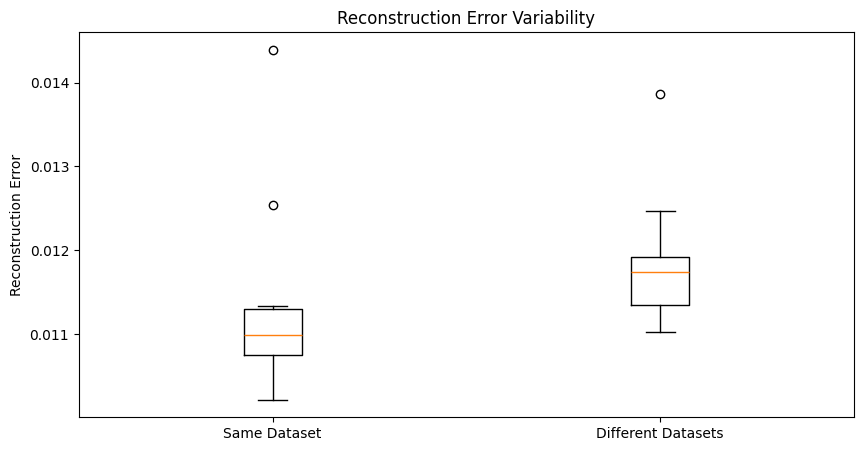

In [40]:
num_repeat=10 # number of times experiment is repeated

errors_same, errors_diff = repeat_training_experiments(num_repeat, n_samples, model, epochs, device)

reconstruction_eror_result = {
    'Same Dataset': [np.mean(errors_same), np.std(errors_same)],
    'Different Dataset': [np.mean(errors_diff), np.std(errors_diff)]
}

df = pd.DataFrame.from_dict(reconstruction_eror_result)
df.index = ['Mean', 'Standard deviation']
print(df)

# Plot results
plt.figure(figsize=(10, 5))
plt.boxplot([errors_same, errors_diff], tick_labels=["Same Dataset", "Different Datasets"])
plt.title("Reconstruction Error Variability")
plt.ylabel("Reconstruction Error")
plt.show()


**comment**

### 1.3

In [41]:
from sklearn.mixture import GaussianMixture

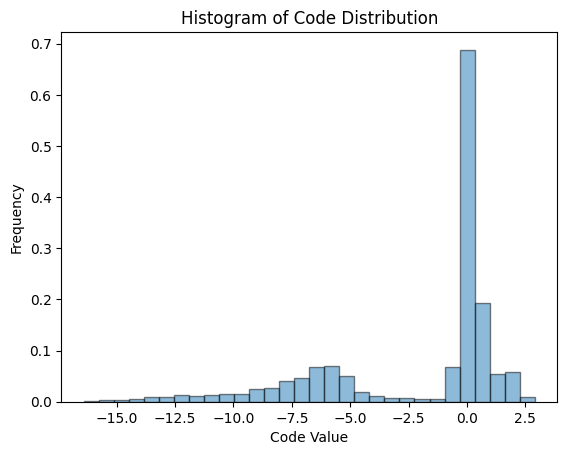

In [42]:
data, _ = make_moons(n_samples=n_samples, noise=noise)

# encode data with best found hyperparameters
with torch.no_grad():
    codes = model.encoder(torch.tensor(data, dtype=torch.float32)).numpy()

# Plot the histogram
plt.hist(codes, bins=30, density=True, ec='black', alpha=0.5)
plt.title("Histogram of Code Distribution")
plt.xlabel("Code Value")
plt.ylabel("Frequency")
plt.show()


Elbow Method to determine number of components for GMM

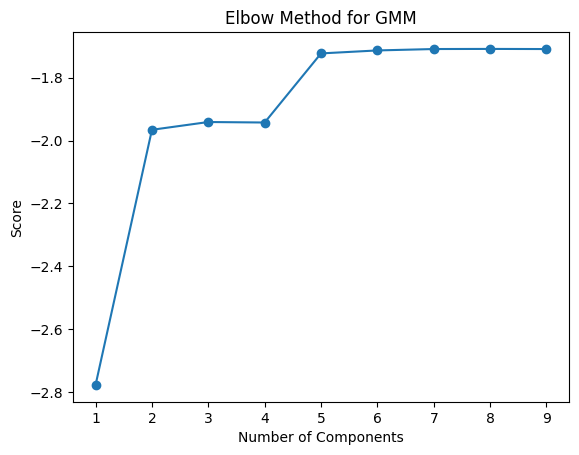

In [43]:
n_components_list = np.arange(1,10)
scores = []

for n in n_components_list:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(codes)
    scores.append(gmm.score(codes))

plt.plot(n_components_list, scores, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.title("Elbow Method for GMM")
plt.show()


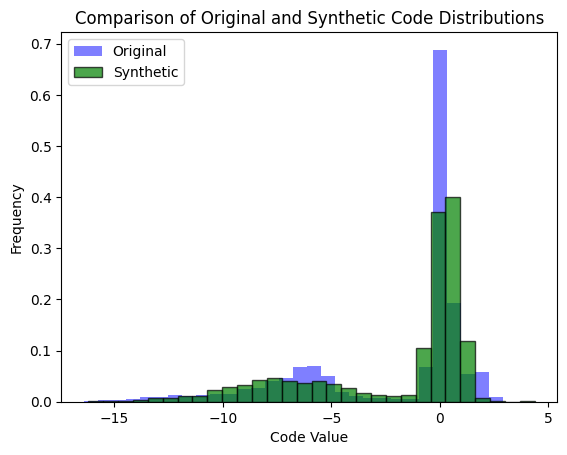

In [44]:
# fit a GMM with number of components
gmm = GaussianMixture(n_components=2, random_state=1)
gmm.fit(codes)

# generate synthetic samples
synthetic_codes = gmm.sample(n_samples=n_samples)[0]


plt.hist(codes, bins=30, density=True, alpha=0.5, color='blue', label='Original')
plt.hist(synthetic_codes, bins=30, density=True, ec='black', alpha=0.7, color='green', label='Synthetic')
plt.title("Comparison of Original and Synthetic Code Distributions")
plt.xlabel("Code Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


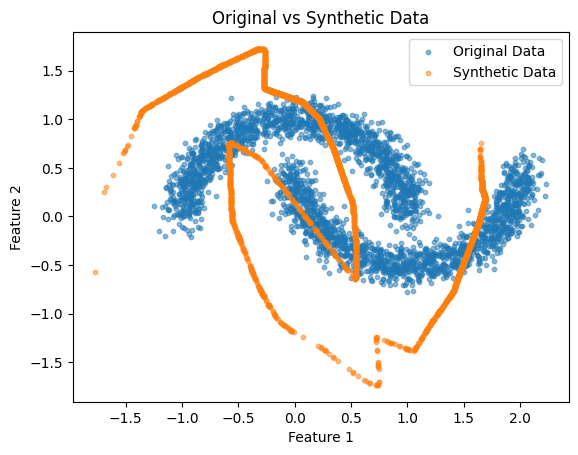

In [45]:
# decode synthetic codes into data space
with torch.no_grad():
    synthetic_data = model.decoder(torch.tensor(synthetic_codes, dtype=torch.float32)).numpy()

# plot original vs synthetic data
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, label='Original Data')
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5, s=10, label='Synthetic Data')
plt.title("Original vs Synthetic Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


**comment**

### 1.4

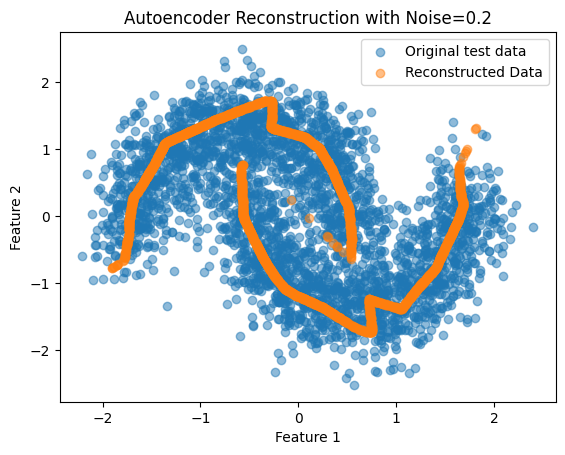

In [46]:
noise = 0.2

test_data = generate_test_data(n_samples=n_samples, noise=noise)

with torch.no_grad():
    reconstructed_data = model(test_data)


plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.5, label="Original test data")
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label="Reconstructed Data")

# Plot formatting
plt.title(f'Autoencoder Reconstruction with Noise={noise}')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

---

### 1.5

Epoch [1/200], Loss: 0.050
Epoch [2/200], Loss: 0.048
Epoch [3/200], Loss: 0.051
Epoch [4/200], Loss: 0.047
Epoch [5/200], Loss: 0.048
Epoch [6/200], Loss: 0.047
Epoch [7/200], Loss: 0.049
Epoch [8/200], Loss: 0.048
Epoch [9/200], Loss: 0.052
Epoch [10/200], Loss: 0.052
Epoch [11/200], Loss: 0.058
Epoch [12/200], Loss: 0.065
Epoch [13/200], Loss: 0.071
Epoch [14/200], Loss: 0.056
Epoch [15/200], Loss: 0.053
Epoch [16/200], Loss: 0.058
Epoch [17/200], Loss: 0.055
Epoch [18/200], Loss: 0.051
Epoch [19/200], Loss: 0.053
Epoch [20/200], Loss: 0.048
Epoch [21/200], Loss: 0.050
Epoch [22/200], Loss: 0.048
Epoch [23/200], Loss: 0.048
Epoch [24/200], Loss: 0.049
Epoch [25/200], Loss: 0.049
Epoch [26/200], Loss: 0.050
Epoch [27/200], Loss: 0.048
Epoch [28/200], Loss: 0.048
Epoch [29/200], Loss: 0.046
Epoch [30/200], Loss: 0.047
Epoch [31/200], Loss: 0.047
Epoch [32/200], Loss: 0.045
Epoch [33/200], Loss: 0.045
Epoch [34/200], Loss: 0.044
Epoch [35/200], Loss: 0.045
Epoch [36/200], Loss: 0.043
E

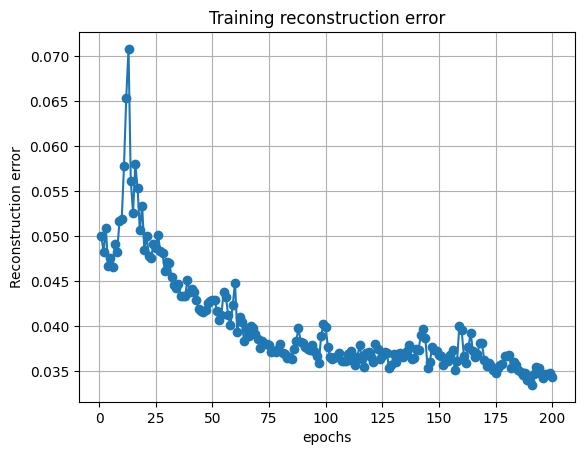

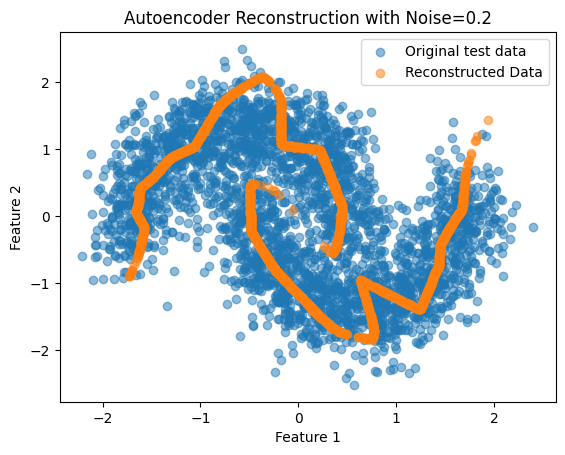

In [47]:
noise = 0.2

train_data = generate_training_data(n_samples, noise)

train_model(model, train_data, optimizer, loss_func, epochs, device)

test_data = generate_test_data(n_samples=n_samples, noise=noise)

with torch.no_grad():
    reconstructed_data = model(test_data)


plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.5, label="Original test data")
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label="Reconstructed Data")

# Plot formatting
plt.title(f'Autoencoder Reconstruction with Noise={noise}')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()